# Advanced Data Science - Capstone Project

## Model Evaluation - V.2.0

### Carlos Granados

For this project I decided to use solar power generation data uploaded by [Ani Kannal](https://www.kaggle.com/anikannal "Ani Kannal Profile") in [kaggle.com website](https://www.kaggle.com/anikannal/solar-power-generation-data?select=Plant_1_Generation_Data.csv "Data Set from kaggle"). The idea is to predict the power generation given different weather conditions, as temperature and irradiation, and check the health of the devices.

#### NOTE:
The data sets are ready to be used. We perform here the steps pn ETL, data cleasing and feature engineering in a few cells...

### 0. Install TensorFlow and Keras:

Usually `TensorFlow` and `keras` are not installed by default, so we need to install them first...

In [1]:
!pip install tensorflow==2.2.0rc0

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# On labs.cognitiveclass.ai the V 2.4.3 must be installed
# On IBM Watson it is not necessary to specify
!pip install keras==2.4.3

Defaulting to user installation because normal site-packages is not writeable


### 1. Load Libraries:

In [3]:
# Standard python libraries
import numpy as np
import types
import datetime as dt
from scipy import stats
from numpy.random import seed
from math import ceil

# pandas
import pandas as pd

# Libraries to make plots and related
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# For Anomaly Detection, using keras
from keras.models import load_model
from keras.losses import MSE, MSLE
from keras.callbacks import Callback
import tensorflow as tf

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from joblib import dump, load

# Custom functions used through this notebook:
from ADS_Capstone_model_evaluation_Aux import *

# Custom functions defined in other part of the project and needed here:
from ADS_Capstone_model_train_Aux import divideTimeSteps, dataProcess
from ADS_Capstone_model_train_Aux import customNorm, create_trimmed_data_norm

# Others, required by IBM Watson
#import ibm_boto3
#from botocore.client import Config

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


### 2. Re-Read and Check Data Frames

Before to start, lets repeat a couple of steps performed in the *Data Exploration* step.

Some cells are hidden, because they contain sensitive information, as some keys and passwords. The original data files, in CSV format, are already uploaded to IBM Watson project, and they are called from the notebook directly.

#### Note:
When using IBM Watson, the following cells can be (uncommented and) executed in order to read de CSV files directly from the cloud. Otherwise the files must be loaded more "traditionally" (see below)

In [4]:
# @hidden_cell
#Created by IBM Watson, to load the data files already present in the project assets

#def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
#client_1332bfda1943460d8a3027fa1d74a9ab = ibm_boto3.client(service_name='s3',
#    ibm_api_key_id='PEEJQvt8RIdfeA43BnAcNewwGbaGVn6ePGzhsbzcVLoG',
#    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
#    config=Config(signature_version='oauth'),
#    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

In [5]:
# @hidden_cell

# Plant 1, generation and sensor data

#body0 = client_1332bfda1943460d8a3027fa1d74a9ab.get_object(
#    Bucket='appliedaideeplearning-donotdelete-pr-8geft8l4hehwko',
#    Key='Plant_1_Generation_Data.csv')['Body']

# add missing __iter__ method, so pandas accepts body as file-like object
#if not hasattr(body0, "__iter__"): body0.__iter__ = types.MethodType( __iter__, body0 )
    
#body1 = client_1332bfda1943460d8a3027fa1d74a9ab.get_object(
#    Bucket='appliedaideeplearning-donotdelete-pr-8geft8l4hehwko',
#    Key='Plant_1_Weather_Sensor_Data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
#if not hasattr(body1, "__iter__"): body1.__iter__ = types.MethodType( __iter__, body1 )

In [6]:
# Read generation data for Plant 1
#df_plant1_gen = pd.read_csv(body0)

# Read sensor data for Plant 1
#df_plant1_sen = pd.read_csv(body1)

In [7]:
# @hidden_cell

# Plant 2, generation and sensor data

#body0 = client_1332bfda1943460d8a3027fa1d74a9ab.get_object(
#    Bucket='appliedaideeplearning-donotdelete-pr-8geft8l4hehwko',
#    Key='Plant_2_Generation_Data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
#if not hasattr(body0, "__iter__"): body0.__iter__ = types.MethodType( __iter__, body0 )

#body1 = client_1332bfda1943460d8a3027fa1d74a9ab.get_object(
#    Bucket='appliedaideeplearning-donotdelete-pr-8geft8l4hehwko',
#    Key='Plant_2_Weather_Sensor_Data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
#if not hasattr(body1, "__iter__"): body1.__iter__ = types.MethodType( __iter__, body1 )

In [8]:
# Read generation data for Plant 2
#df_plant2_gen = pd.read_csv(body0)

# Read sensor data for Plant 2
#df_plant2_sen = pd.read_csv(body1)

#### Note:
Execute the following lines when running on cognitiveclass.ai or another platform...

In [9]:
# Path to CSV data files
#path_data = '/resources/Projects/AnomalyDect/SolarPanels/Data/'
path_data = './Data/'

# Read generation data for Plant 1
df_plant1_gen = pd.read_csv(path_data+'Plant_1_Generation_Data.csv')

# Read sensor data for Plant 1
df_plant1_sen = pd.read_csv(path_data+'Plant_1_Weather_Sensor_Data.csv')

In [10]:
# Read generation data for Plant 2
df_plant2_gen = pd.read_csv(path_data+'Plant_2_Generation_Data.csv')

# Read sensor data for Plant 2
df_plant2_sen = pd.read_csv(path_data+'Plant_2_Weather_Sensor_Data.csv')

We create now a huge function that makes all the ETL, data cleasing and feature engineering for us!

In [11]:
# Create DF with all times...
t = np.arange(0, 24, 0.25)
times = []
headers = ['TIME', 'DAY', 'MONTH']

# Add days for May
for day in range(15, 32):
    for i in range(96):
        times.append([t[i], day, 5])

# Add days for June
for day in range(1, 18):
    for i in range(96):
        times.append([t[i], day, 6])
        
times = np.array(times)
df_times = pd.DataFrame(data=times, columns=headers)

Let's extract the 7 first sources for the plant 1 (used for training):

In [12]:
nDay_p1 = 10
nMonth_p1 = 5
df1_all = dataProcess(df_plant1_gen, df_plant1_sen, df_times, 7, nDay=nDay_p1, nMonth=nMonth_p1)

Extracting data for Source Key : bvBOhCH3iADSZry
Extracting data for Source Key : 1BY6WEcLGh8j5v7
Extracting data for Source Key : 7JYdWkrLSPkdwr4
Extracting data for Source Key : VHMLBKoKgIrUVDU
Extracting data for Source Key : ZnxXDlPa8U1GXgE
Extracting data for Source Key : ih0vzX44oOqAx2f
Extracting data for Source Key : z9Y9gH1T5YWrNuG


And now some additional data sources, for evaluate the model...

In [13]:
df1_new = dataProcess(df_plant1_gen, df_plant1_sen, df_times, 15, nDay=nDay_p1, nMonth=nMonth_p1)

Extracting data for Source Key : bvBOhCH3iADSZry
Extracting data for Source Key : 1BY6WEcLGh8j5v7
Extracting data for Source Key : 7JYdWkrLSPkdwr4
Extracting data for Source Key : VHMLBKoKgIrUVDU
Extracting data for Source Key : ZnxXDlPa8U1GXgE
Extracting data for Source Key : ih0vzX44oOqAx2f
Extracting data for Source Key : z9Y9gH1T5YWrNuG
Extracting data for Source Key : wCURE6d3bPkepu2
Extracting data for Source Key : uHbuxQJl8lW7ozc
Extracting data for Source Key : pkci93gMrogZuBj
Extracting data for Source Key : iCRJl6heRkivqQ3
Extracting data for Source Key : sjndEbLyjtCKgGv
Extracting data for Source Key : zVJPv84UY57bAof
Extracting data for Source Key : McdE0feGgRqW7Ca
Extracting data for Source Key : rGa61gmuvPhdLxV


And for the 7 first sources for the plant 2:

In [14]:
df2_all = dataProcess(df_plant2_gen, df_plant2_sen, df_times, 7)

Extracting data for Source Key : LYwnQax7tkwH5Cb
Extracting data for Source Key : oZZkBaNadn6DNKz
Extracting data for Source Key : rrq4fwE8jgrTyWY
Extracting data for Source Key : V94E5Ben1TlhnDV
Extracting data for Source Key : 81aHJ1q11NBPMrL
Extracting data for Source Key : LlT2YUhhzqhg5Sw
Extracting data for Source Key : 9kRcWv60rDACzjR


With the additional data sources, to be used in the evaluation:

In [15]:
df2_new = dataProcess(df_plant2_gen, df_plant2_sen, df_times, 15)

Extracting data for Source Key : LYwnQax7tkwH5Cb
Extracting data for Source Key : oZZkBaNadn6DNKz
Extracting data for Source Key : rrq4fwE8jgrTyWY
Extracting data for Source Key : V94E5Ben1TlhnDV
Extracting data for Source Key : 81aHJ1q11NBPMrL
Extracting data for Source Key : LlT2YUhhzqhg5Sw
Extracting data for Source Key : 9kRcWv60rDACzjR
Extracting data for Source Key : q49J1IKaHRwDQnt
Extracting data for Source Key : WcxssY2VbP4hApt
Extracting data for Source Key : vOuJvMaM2sgwLmb
Extracting data for Source Key : PeE6FRyGXUgsRhN
Extracting data for Source Key : xoJJ8DcxJEcupym
Extracting data for Source Key : Quc1TzYxW2pYoWX
Extracting data for Source Key : Qf4GUc1pJu5T6c6
Extracting data for Source Key : Mx2yZCDsyf6DPfv


We will try to generate now some new data frames, which will contain three different types of data from the sensors: 1.) a set of the original one, 2.) a modified set, where the power output is slightly smaller, 3.) new data sets from different sources and 4.) the new sets with smaller power output.

We need first create a new array with several random numbers, between 0.75 and 0.25, in order to simulate a faulty solar panel... Such array will be converted to a data frame.

In [16]:
# Some initial parameters
amin = 0.75                  # Min val.
amax = 1.25                  # Max val.
nmax = 10                    # Upper limit in the random generation
nrows = df1_all[0].shape[0]  # Number of rows

df_alpha = randDF(10)
df_alpha.head()

,alpha
0,1.15
1,1.25
2,1.15
3,0.80
4,1.20


And let's see the statistics about this random vector:

In [17]:
df_alpha.describe()

,alpha
count,10.000000
mean,1.020000
std,0.163639
min,0.800000
25%,0.862500
50%,1.025000
75%,1.150000
max,1.250000


We define now a funtion that helps us to generate the data to be used in the evaluation...

**NOTE:** The function `genTest` and all its auxiliar functions are defined in the corresponding helper file.

Now we can generate some evaluation data!

In [18]:
df1_eval = genTest(df1_all, df1_new, 8.00, nDay_p1, nMonth_p1, n0=5, n1=5, x0=0.65, verbose=0)
#df2_eval = genTest(df2_all, df2_new, nMonth=6, t_min=7.00, t_max=11.00)

In [19]:
len(df1_eval)

40

In [20]:
df1_eval[0].describe()

,TIME,DAY,MONTH,AMB_TEMP,MOD_TEMP,IRRADIATION,AC_POWER,DC_POWER
count,16.000000,16.0,16.0,16.000000,16.000000,16.000000,16.000000,16.000000
mean,9.875000,15.0,5.0,28.221852,44.180301,0.458193,522.556362,5332.362723
std,1.190238,0.0,0.0,1.594269,5.891880,0.145720,157.538326,1614.872386
min,8.000000,15.0,5.0,25.419513,31.412545,0.201639,286.814286,2921.571429
25%,8.937500,15.0,5.0,27.295538,40.022625,0.345502,413.902679,4215.383928
50%,9.875000,15.0,5.0,28.310277,45.813470,0.461568,505.731250,5157.276786
75%,10.812500,15.0,5.0,29.366287,48.189718,0.575659,628.721429,6418.107143
max,11.750000,15.0,5.0,30.811049,52.547736,0.670675,821.228571,8394.428571


In [21]:
df1_eval[1].describe()

,TIME,DAY,MONTH,AMB_TEMP,MOD_TEMP,IRRADIATION,AC_POWER,DC_POWER
count,16.000000,16.0,16.0,16.000000,16.000000,16.000000,16.000000,16.000000
mean,9.875000,15.0,5.0,28.221852,44.180301,0.458193,339.661635,3466.035770
std,1.190238,0.0,0.0,1.594269,5.891880,0.145720,102.399912,1049.667051
min,8.000000,15.0,5.0,25.419513,31.412545,0.201639,186.429286,1899.021429
25%,8.937500,15.0,5.0,27.295538,40.022625,0.345502,269.036741,2739.999553
50%,9.875000,15.0,5.0,28.310277,45.813470,0.461568,328.725312,3352.229911
75%,10.812500,15.0,5.0,29.366287,48.189718,0.575659,408.668929,4171.769643
max,11.750000,15.0,5.0,30.811049,52.547736,0.670675,533.798571,5456.378571


In [22]:
df1_eval[2].describe()

,TIME,DAY,MONTH,AMB_TEMP,MOD_TEMP,IRRADIATION,AC_POWER,DC_POWER
count,16.000000,16.0,16.0,16.000000,16.000000,16.000000,16.000000,16.000000
mean,13.875000,15.0,5.0,33.132119,48.798323,0.571839,469.091289,4792.674163
std,1.190238,0.0,0.0,1.034558,3.238102,0.155240,105.745496,1085.121454
min,12.000000,15.0,5.0,31.305375,43.920616,0.346231,283.050625,2887.625000
25%,12.937500,15.0,5.0,32.470653,46.725677,0.461915,393.218951,4013.297322
50%,13.875000,15.0,5.0,33.187097,48.400889,0.551562,461.785536,4716.115625
75%,14.812500,15.0,5.0,34.053154,50.041179,0.670707,553.809866,5661.076339
max,15.750000,15.0,5.0,34.430943,55.030613,0.893661,671.823750,6876.268750


In [23]:
df1_eval[3].describe()

,TIME,DAY,MONTH,AMB_TEMP,MOD_TEMP,IRRADIATION,AC_POWER,DC_POWER
count,16.000000,16.0,16.0,16.000000,16.000000,16.000000,16.000000,16.000000
mean,17.875000,15.0,5.0,30.682984,32.162776,0.112026,143.815474,1466.837798
std,1.190238,0.0,0.0,3.375543,6.763120,0.139087,182.717585,1860.678639
min,16.000000,15.0,5.0,23.787237,22.511406,0.000000,0.000000,0.000000
25%,16.937500,15.0,5.0,27.777042,25.907777,0.000119,0.000000,0.000000
50%,17.875000,15.0,5.0,31.722142,30.886935,0.030474,38.557679,398.980357
75%,18.812500,15.0,5.0,33.547884,37.474797,0.195511,230.391563,2348.690625
max,19.750000,15.0,5.0,34.381150,43.332853,0.358182,513.228571,5229.707143


In [24]:
df1_eval[7].describe()

,TIME,DAY,MONTH,AMB_TEMP,MOD_TEMP,IRRADIATION,AC_POWER,DC_POWER
count,16.000000,16.0,16.0,16.000000,16.000000,16.000000,16.000000,16.000000
mean,17.875000,17.0,5.0,27.767094,29.636403,0.111880,124.927751,1275.308929
std,1.190238,0.0,0.0,2.475144,6.316909,0.145636,154.437690,1573.863943
min,16.000000,17.0,5.0,25.816387,24.024733,0.000000,0.000000,0.000000
25%,16.937500,17.0,5.0,25.993429,24.502894,0.000000,0.000000,0.000000
50%,17.875000,17.0,5.0,26.541544,27.165636,0.042674,56.704509,584.993304
75%,18.812500,17.0,5.0,28.904004,33.608604,0.170218,203.797500,2077.987500
max,19.750000,17.0,5.0,34.737508,44.045326,0.453366,416.775000,4254.642857


### 3. Deep Learning Model Evaluation

In the model definition phase we explored different deep learning models, and the one that had the best behavior were a sequential one, with several layers. In the training phase such model were used and saved. Here we load such model and use it in two stages: 1.) to evaluate how good the model is and 2.) using it when "broken" data is used to verify how the losses change and then to identify a possible problem in the solar panels.

The FFT of the data is not considered, since several of the time parameters (such as time and day and month) are needed to build up the model.

#### 3.1 Auxiliary Functions Definition

We start defining a class to normalize the data, according to the values in the "healthy" data sets, the functions to reshape and normalize the data, and to obtain the losses and plot them.

**Note:** the class `customNorm` and the `create_trimmed_data_norm` function are defined in the helper file for the model training.

And we calculate explicitly the loss function, only considering the DC and AC values:

We define also a function to return the score...

**Note:** The function `lossCalc`, `predData`, `scoreAll`, `predictModel`  and its auxiliary functions are defined in the corresponging helper file.

Function to define the training of the model:

In [25]:
#losses = []#
#
#def handleLoss(loss):
#    global losses
#    losses += [loss]
#    print(loss)
#
#class LossHistory(Callback):
#    def on_train_begin(self, logs={}):
#        self.losses = []
#        self.acc = []#
#
#    def on_batch_end(self, batch, logs={}):
#        self.losses.append(logs.get('loss'))
#        self.acc.append(logs.get('accuracy'))
#        handleLoss(logs.get('loss'))

Function to detect an anomaly, based on the changes of the loss function. A warning is issued if a change larger than the 10% respect to a reference value is detected.

In [26]:
def checkVal(score, indx=0):
    """
    Function to check the Anomaly boolean value in score DF
    """
    s0 = score['Anomaly'].unique()
    if True in s0:
        print('Warning! Possible anomaly detected in entry {}'.format(indx))

def checkPanel(df_test, df_eval, time_steps, batch_size, model, scaler,
               lossFun='mse', l_min=0.1):
    """
    Function designed to give warnings, when the loss function is larger than a given value
    df_test : DF, using for the training of model
    df_eval : DF, used to test the validity of model
    model   : previusly trained model, using df_test
    loss    : (str) loss function to use. 'MSE' by default
    """
    # Check loss with data used during the training phase
    score_all = {}
    icount = 0
    for i in df_test:
        df = df_test[i]
        if i == 0:
            score = predictModel(df, model, create_trimmed_data_norm,
                                 scaler, time_steps, batch_size,
                                 lossFun=lossFun, l_min=l_min)
            checkVal(score)
        else:
            score_loop = predictModel(df, model, create_trimmed_data_norm,
                                      scaler, time_steps, batch_size,
                                      lossFun=lossFun, l_min=l_min)
            checkVal(score_loop, indx=-i)
            score = pd.concat([score_loop, score])
    score_all[icount] = score
    icount += 1
    # Check the loss for each validation data
    loss_val = {}
    for i in df_eval:
        df = df_eval[i]
        score = predictModel(df, model, create_trimmed_data_norm,
                             scaler, time_steps, batch_size,
                             lossFun=lossFun, l_min=l_min)
        score_all[icount] = score
        loss_val[i] = score
        icount += 1
        # Check if there is some anomalies (loss values over the threshold)
        checkVal(score, indx=i)
    return [score_all, loss_val]

**NOTE:** The functions `colorPalette`, `plotLosses` and `plotTimeLosses` are defined in the corresponding helper file.

#### 3.2 Evaluation:

We start evaluating the model for the used data sets in the training.

First we need to load the model for the solar panel 1:

In [27]:
model1 = load_model('./models/ADS_Capstone.solar_panel_1.model.h5')

Let's check the summary:

In [28]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 20)            2320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 20)            3280      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16, 20)            3280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16, 20)            3280      
_________________________________________________________________
lstm_4 (LSTM)                (None, 16, 20)            3280      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16, 20)            3280      
_________________________________________________________________
lstm_6 (LSTM)                (None, 16, 20)            3

In [29]:
print(model1.metrics_names)

[]


And the we continue with the evaluation. First the escores for the data used in the training phase:

In [30]:
time_steps = 16      # Equivalent to obtained observations in a 4 hour period
dim = 8              # Number of considered parameters
batch_size = 4      # Best batch:size obtained in evaluation of the model

# Initialize scaler
scaler1 = customNorm(df_plant1_gen, df_plant1_sen)

# Check loss for data used in training
scoreAll(df1_all, time_steps, scaler1, model1)

df : 0
1/1 [==============================] - 0s 2ms/step
Loss : count    16.000000
mean      0.100335
std       0.000895
min       0.098841
25%       0.099855
50%       0.100284
75%       0.101039
max       0.101669
Name: Loss, dtype: float64
---------------------------

df : 1
1/1 [==============================] - 0s 1000us/step
Loss : count    16.000000
mean      0.071108
std       0.003196
min       0.068198
25%       0.068845
50%       0.069627
75%       0.073010
max       0.077128
Name: Loss, dtype: float64
---------------------------

df : 2
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.115856
std       0.037331
min       0.059953
25%       0.082463
50%       0.118387
75%       0.143799
max       0.170699
Name: Loss, dtype: float64
---------------------------

df : 3
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.149313
std       0.048269
min       0.086123
25%       0.113698
50%       0.139175

1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.090891
std       0.001089
min       0.088089
25%       0.090697
50%       0.091196
75%       0.091552
max       0.092170
Name: Loss, dtype: float64
---------------------------

df : 31
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.063978
std       0.007771
min       0.059988
25%       0.060419
50%       0.060623
75%       0.061563
max       0.087152
Name: Loss, dtype: float64
---------------------------

df : 32
1/1 [==============================] - 0s 2ms/step
Loss : count    16.000000
mean      0.191893
std       0.075415
min       0.077771
25%       0.126650
50%       0.199150
75%       0.245886
max       0.302711
Name: Loss, dtype: float64
---------------------------

df : 33
1/1 [==============================] - 0s 883us/step
Loss : count    16.000000
mean      0.148955
std       0.106106
min       0.063965
25%       0.067991
50%       0.072852
75% 

1/1 [==============================] - 0s 865us/step
Loss : count    16.000000
mean      0.087156
std       0.000869
min       0.085166
25%       0.086610
50%       0.087208
75%       0.087883
max       0.088379
Name: Loss, dtype: float64
---------------------------

df : 61
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.070223
std       0.022747
min       0.055474
25%       0.056438
50%       0.057834
75%       0.070098
max       0.119872
Name: Loss, dtype: float64
---------------------------

df : 62
1/1 [==============================] - 0s 880us/step
Loss : count    16.000000
mean      0.204474
std       0.082771
min       0.056451
25%       0.138548
50%       0.219305
75%       0.276737
max       0.307463
Name: Loss, dtype: float64
---------------------------

df : 63
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.232773
std       0.048705
min       0.143242
25%       0.202227
50%       0.247897
75

1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.092147
std       0.000973
min       0.089636
25%       0.091836
50%       0.092483
75%       0.092690
max       0.093382
Name: Loss, dtype: float64
---------------------------

df : 91
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.064008
std       0.005317
min       0.060496
25%       0.061086
50%       0.061170
75%       0.063772
max       0.077106
Name: Loss, dtype: float64
---------------------------

df : 92
1/1 [==============================] - 0s 2ms/step
Loss : count    16.000000
mean      0.106428
std       0.047539
min       0.042190
25%       0.070152
50%       0.096360
75%       0.142659
max       0.218444
Name: Loss, dtype: float64
---------------------------

df : 93
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.145358
std       0.052326
min       0.076058
25%       0.093252
50%       0.143832
75%   

1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.087295
std       0.000896
min       0.085360
25%       0.086754
50%       0.087225
75%       0.088007
max       0.088696
Name: Loss, dtype: float64
---------------------------

df : 121
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.060845
std       0.008815
min       0.055802
25%       0.056482
50%       0.056787
75%       0.059688
max       0.086555
Name: Loss, dtype: float64
---------------------------

df : 122
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.175842
std       0.091562
min       0.070599
25%       0.104147
50%       0.140509
75%       0.257251
max       0.341954
Name: Loss, dtype: float64
---------------------------

df : 123
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.199089
std       0.080871
min       0.049762
25%       0.162343
50%       0.197115
75%

1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.094386
std       0.001314
min       0.091237
25%       0.094032
50%       0.094816
75%       0.095181
max       0.096016
Name: Loss, dtype: float64
---------------------------

df : 151
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.066187
std       0.005225
min       0.063019
25%       0.063670
50%       0.064406
75%       0.065424
max       0.083192
Name: Loss, dtype: float64
---------------------------

df : 152
1/1 [==============================] - 0s 990us/step
Loss : count    16.000000
mean      0.063042
std       0.030026
min       0.041201
25%       0.042529
50%       0.043960
75%       0.091001
max       0.126129
Name: Loss, dtype: float64
---------------------------

df : 153
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.150039
std       0.062241
min       0.074293
25%       0.120961
50%       0.131810
7

1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.088301
std       0.001188
min       0.085376
25%       0.088053
50%       0.088658
75%       0.089007
max       0.089688
Name: Loss, dtype: float64
---------------------------

df : 181
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.081809
std       0.027438
min       0.057133
25%       0.057615
50%       0.068779
75%       0.108599
max       0.127473
Name: Loss, dtype: float64
---------------------------

df : 182
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.199815
std       0.085760
min       0.069049
25%       0.152685
50%       0.177843
75%       0.220335
max       0.367169
Name: Loss, dtype: float64
---------------------------

df : 183
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.216887
std       0.091454
min       0.095914
25%       0.138150
50%       0.199832
75%

1/1 [==============================] - 0s 934us/step
Loss : count    16.000000
mean      0.095456
std       0.000892
min       0.093255
25%       0.095024
50%       0.095630
75%       0.096142
max       0.096672
Name: Loss, dtype: float64
---------------------------

df : 211
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.068899
std       0.009064
min       0.064415
25%       0.064867
50%       0.065041
75%       0.066427
max       0.098272
Name: Loss, dtype: float64
---------------------------

df : 212
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.217430
std       0.095241
min       0.090250
25%       0.139741
50%       0.232690
75%       0.298142
max       0.367741
Name: Loss, dtype: float64
---------------------------

df : 213
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.163635
std       0.051461
min       0.073725
25%       0.122311
50%       0.166566
7

1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.088365
std       0.000882
min       0.086142
25%       0.087904
50%       0.088544
75%       0.089010
max       0.089512
Name: Loss, dtype: float64
---------------------------

df : 241
1/1 [==============================] - 0s 999us/step
Loss : count    16.000000
mean      0.064530
std       0.014049
min       0.057068
25%       0.057601
50%       0.058091
75%       0.060468
max       0.099018
Name: Loss, dtype: float64
---------------------------

df : 242
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.142436
std       0.099501
min       0.045633
25%       0.082126
50%       0.104552
75%       0.157478
max       0.381256
Name: Loss, dtype: float64
---------------------------

df : 243
1/1 [==============================] - 0s 961us/step
Loss : count    16.000000
mean      0.214030
std       0.076970
min       0.067025
25%       0.189818
50%       0.212368

1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.130997
std       0.034654
min       0.095369
25%       0.098154
50%       0.127270
75%       0.164519
max       0.168643
Name: Loss, dtype: float64
---------------------------

df : 271
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.069821
std       0.004903
min       0.067104
25%       0.067459
50%       0.067705
75%       0.069344
max       0.085498
Name: Loss, dtype: float64
---------------------------

df : 272
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.139886
std       0.043184
min       0.072815
25%       0.104216
50%       0.145159
75%       0.169371
max       0.220565
Name: Loss, dtype: float64
---------------------------

df : 273
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.158272
std       0.058084
min       0.065294
25%       0.121103
50%       0.142143
75%

1/1 [==============================] - 0s 964us/step
Loss : count    16.000000
mean      0.147760
std       0.009208
min       0.134516
25%       0.140053
50%       0.145348
75%       0.156065
max       0.160191
Name: Loss, dtype: float64
---------------------------

df : 301
1/1 [==============================] - 0s 2ms/step
Loss : count    16.000000
mean      0.115556
std       0.011220
min       0.088417
25%       0.108655
50%       0.113848
75%       0.124694
max       0.129033
Name: Loss, dtype: float64
---------------------------

df : 302
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.204247
std       0.092543
min       0.068152
25%       0.132857
50%       0.197516
75%       0.255698
max       0.380841
Name: Loss, dtype: float64
---------------------------

df : 303
1/1 [==============================] - 0s 2ms/step
Loss : count    16.000000
mean      0.189637
std       0.071384
min       0.085991
25%       0.129488
50%       0.196873
7

1/1 [==============================] - 0s 866us/step
Loss : count    16.000000
mean      0.100335
std       0.000895
min       0.098841
25%       0.099855
50%       0.100284
75%       0.101039
max       0.101669
Name: Loss, dtype: float64
---------------------------

df : 331
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.071308
std       0.003475
min       0.068198
25%       0.068845
50%       0.069634
75%       0.073615
max       0.077642
Name: Loss, dtype: float64
---------------------------

df : 332
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.125363
std       0.044546
min       0.061792
25%       0.090313
50%       0.127637
75%       0.160677
max       0.190990
Name: Loss, dtype: float64
---------------------------

df : 333
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.156041
std       0.055768
min       0.094213
25%       0.114208
50%       0.148634
7

1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.090891
std       0.001089
min       0.088089
25%       0.090697
50%       0.091196
75%       0.091552
max       0.092170
Name: Loss, dtype: float64
---------------------------

df : 361
1/1 [==============================] - 0s 2ms/step
Loss : count    16.000000
mean      0.064245
std       0.008384
min       0.060003
25%       0.060429
50%       0.060623
75%       0.061666
max       0.089428
Name: Loss, dtype: float64
---------------------------

df : 362
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.204600
std       0.081123
min       0.081629
25%       0.136038
50%       0.211458
75%       0.261499
max       0.325762
Name: Loss, dtype: float64
---------------------------

df : 363
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.157593
std       0.117582
min       0.063965
25%       0.067991
50%       0.072852
75%

1/1 [==============================] - 0s 962us/step
Loss : count    16.000000
mean      0.087156
std       0.000869
min       0.085166
25%       0.086610
50%       0.087208
75%       0.087883
max       0.088379
Name: Loss, dtype: float64
---------------------------

df : 391
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.069982
std       0.022731
min       0.055474
25%       0.056438
50%       0.057719
75%       0.069527
max       0.119872
Name: Loss, dtype: float64
---------------------------

df : 392
1/1 [==============================] - 0s 971us/step
Loss : count    16.000000
mean      0.194630
std       0.093930
min       0.048624
25%       0.118961
50%       0.184793
75%       0.296312
max       0.330061
Name: Loss, dtype: float64
---------------------------

df : 393
1/1 [==============================] - 0s 3ms/step
Loss : count    16.000000
mean      0.248778
std       0.056237
min       0.148688
25%       0.208504
50%       0.268072

1/1 [==============================] - 0s 2ms/step
Loss : count    16.000000
mean      0.092147
std       0.000973
min       0.089636
25%       0.091836
50%       0.092483
75%       0.092690
max       0.093382
Name: Loss, dtype: float64
---------------------------

df : 421
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.064366
std       0.005952
min       0.060496
25%       0.061086
50%       0.061173
75%       0.063972
max       0.078481
Name: Loss, dtype: float64
---------------------------

df : 422
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.114029
std       0.054697
min       0.043435
25%       0.073308
50%       0.107894
75%       0.148742
max       0.253930
Name: Loss, dtype: float64
---------------------------

df : 423
1/1 [==============================] - 0s 2ms/step
Loss : count    16.000000
mean      0.156968
std       0.058972
min       0.080807
25%       0.100535
50%       0.158139
75%

1/1 [==============================] - 0s 970us/step
Loss : count    16.000000
mean      0.087295
std       0.000896
min       0.085360
25%       0.086754
50%       0.087225
75%       0.088007
max       0.088696
Name: Loss, dtype: float64
---------------------------

df : 451
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.060986
std       0.009047
min       0.055802
25%       0.056482
50%       0.056797
75%       0.059830
max       0.087212
Name: Loss, dtype: float64
---------------------------

df : 452
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.172435
std       0.086782
min       0.075344
25%       0.105493
50%       0.139817
75%       0.264667
max       0.308091
Name: Loss, dtype: float64
---------------------------

df : 453
1/1 [==============================] - 0s 932us/step
Loss : count    16.000000
mean      0.222024
std       0.088493
min       0.045543
25%       0.180693
50%       0.249006

And for the new data sets:

In [31]:
scoreAll(df1_eval, time_steps, scaler1, model1)

df : 0
1/1 [==============================] - 0s 2ms/step
Loss : count    16.000000
mean      0.115856
std       0.037331
min       0.059953
25%       0.082463
50%       0.118387
75%       0.143799
max       0.170699
Name: Loss, dtype: float64
---------------------------

df : 1
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.094470
std       0.026085
min       0.054029
25%       0.071414
50%       0.097763
75%       0.118694
max       0.127197
Name: Loss, dtype: float64
---------------------------

df : 2
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.109867
std       0.031200
min       0.072631
25%       0.086699
50%       0.102257
75%       0.126653
max       0.189662
Name: Loss, dtype: float64
---------------------------

df : 3
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.032168
std       0.018686
min       0.016538
25%       0.019139
50%       0.024473
75

1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.111243
std       0.032005
min       0.061529
25%       0.081044
50%       0.113519
75%       0.134990
max       0.165394
Name: Loss, dtype: float64
---------------------------

df : 31
1/1 [==============================] - 0s 2ms/step
Loss : count    16.000000
mean      0.024451
std       0.019123
min       0.012876
25%       0.013078
50%       0.014174
75%       0.025715
max       0.068477
Name: Loss, dtype: float64
---------------------------

df : 32
1/1 [==============================] - 0s 2ms/step
Loss : count    16.000000
mean      0.193208
std       0.080922
min       0.083423
25%       0.127732
50%       0.208926
75%       0.266618
max       0.314830
Name: Loss, dtype: float64
---------------------------

df : 33
1/1 [==============================] - 0s 937us/step
Loss : count    16.000000
mean      0.142593
std       0.056866
min       0.067230
25%       0.095852
50%       0.150062
75% 

Let's check if some issues are printed!

In [32]:
[score, loss_eval] = checkPanel(df1_all, df1_eval, time_steps,
                                batch_size, model1, scaler1,
                                lossFun='msle', l_min=0.075)

1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -2
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -3
1/1 [==============================] - 0s 3ms/step
Warning! Possible anomaly detected in entry -6
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -8
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -9
1/1 [==============================] - 0s 2ms/step
Warning! Possible anomaly detected in entry -14
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -15
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -21
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -26
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -27
1/1 [==========

1/1 [==============================] - 0s 929us/step
Warning! Possible anomaly detected in entry -122
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -123
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -128
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -129
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -134
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -135
1/1 [==============================] - 0s 875us/step
Warning! Possible anomaly detected in entry -138
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -140
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -141
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -

1/1 [==============================] - 0s 906us/step
Warning! Possible anomaly detected in entry -242
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -243
1/1 [==============================] - 0s 966us/step
Warning! Possible anomaly detected in entry -248
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -249
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -254
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -255
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -260
1/1 [==============================] - 0s 803us/step
Warning! Possible anomaly detected in entry -261
1/1 [==============================] - 0s 4ms/step
Warning! Possible anomaly detected in entry -262
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry

1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -357
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -362
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -363
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -366
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -368
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -369
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -374
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -375
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -380
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -381


1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry 12
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry 13
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry 14
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry 16
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry 17
1/1 [==============================] - 0s 2ms/step
Warning! Possible anomaly detected in entry 18
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry 20
1/1 [==============================] - 0s 897us/step
Warning! Possible anomaly detected in entry 21
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry 22
1/1 [==============================] - 0s 3ms/step
Warning! Possible anomaly detected in entry 24
1/1 [=============

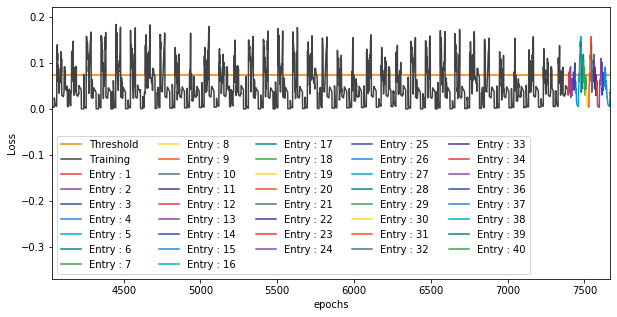

In [33]:
plotLosses(score, c_xmin=0.5, c_xmax=0.95, c_ymin=-2.0, c_ymax=1.2)

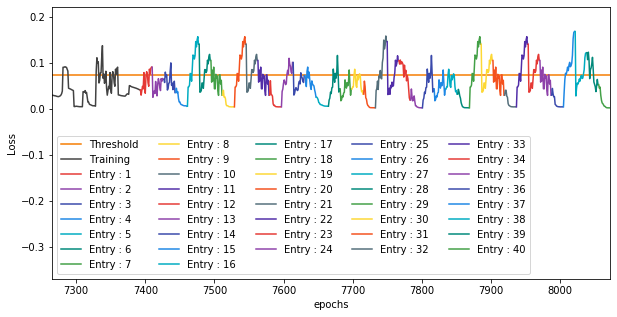

In [43]:
plotLosses(score, c_xmin=0.90, c_ymin=-2.0, c_ymax=1.2)

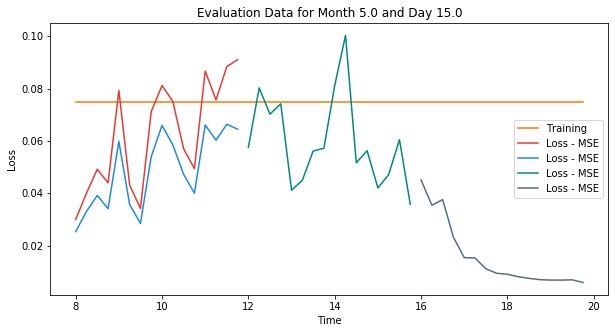

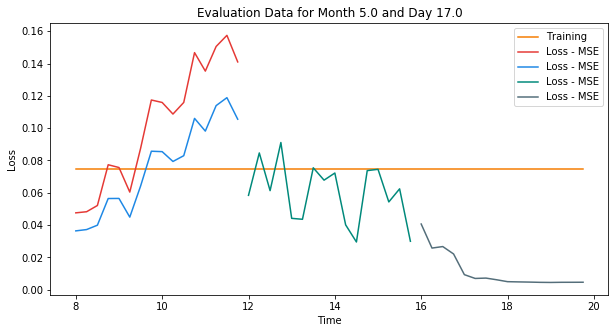

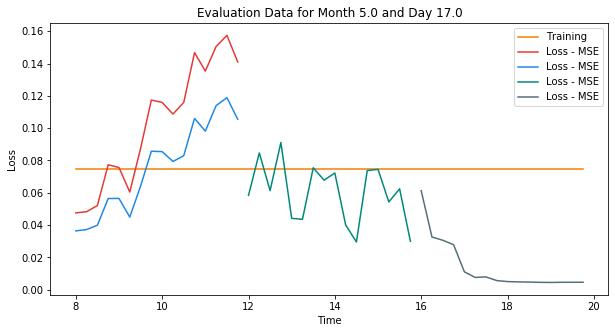

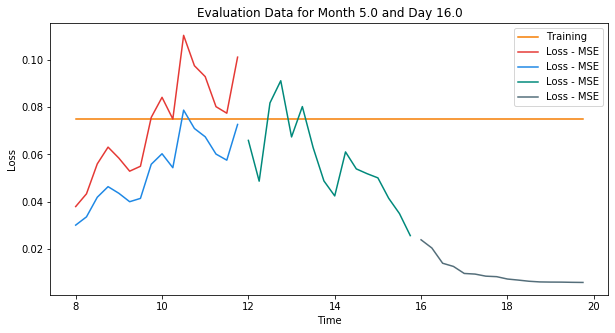

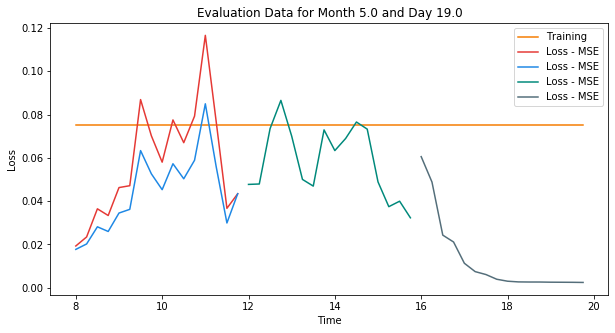

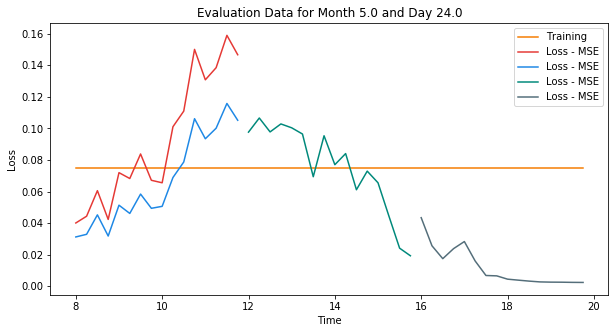

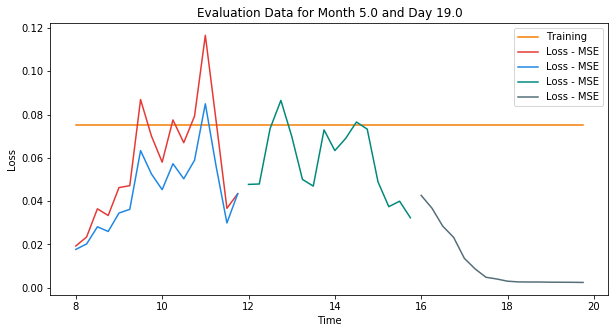

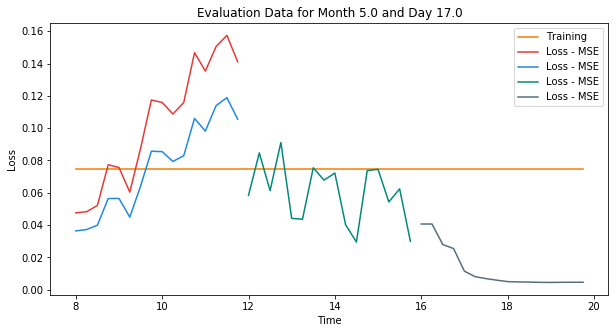

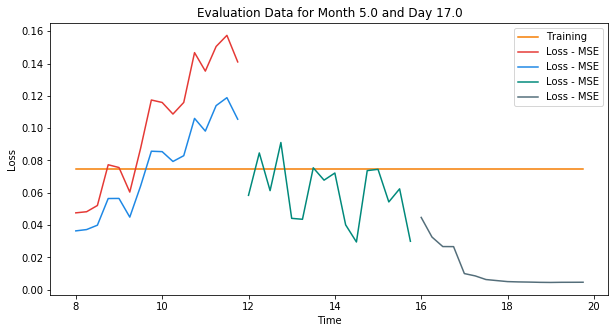

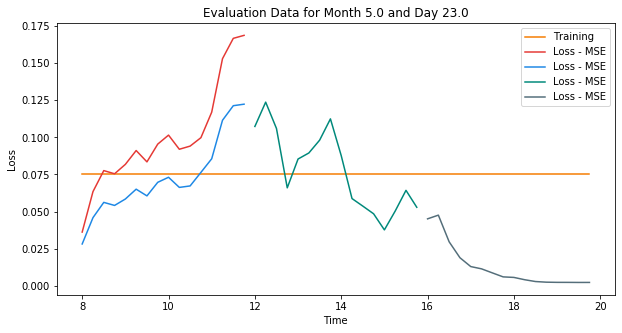

In [35]:
plotTimeLosses(df1_eval, loss_eval)

In [36]:
score

{0:             Loss  Threshold  Anomaly
 0   6.099439e-08      0.075    False
 1   7.311437e-06      0.075    False
 2   4.840083e-06      0.075    False
 3   2.145704e-05      0.075    False
 4   3.434176e-06      0.075    False
 ..           ...        ...      ...
 11  4.439746e-02      0.075    False
 12  4.357394e-02      0.075    False
 13  4.301349e-02      0.075    False
 14  4.233923e-02      0.075    False
 15  4.149301e-02      0.075    False
 
 [7392 rows x 3 columns],
 1:         Loss  Threshold  Anomaly
 0   0.029994      0.075    False
 1   0.040018      0.075    False
 2   0.049148      0.075    False
 3   0.043963      0.075    False
 4   0.079258      0.075     True
 5   0.043108      0.075    False
 6   0.034172      0.075    False
 7   0.071216      0.075    False
 8   0.081144      0.075     True
 9   0.075103      0.075     True
 10  0.056969      0.075    False
 11  0.049398      0.075    False
 12  0.086697      0.075     True
 13  0.075652      0.075     True


### 4. Machine Learning Model Evaluation

In the model definition phase we trained a linear regression machine learning model, usign polynomial features, in order create a model that helps us to make an anomaly detector. We will use the same evaluation data as for the deep learning model.

The FFT of the data is not considered, since several of the time parameters (such as time and day and month) are needed to build up the model.

#### 3.1 Auxiliary Functions Definition



In [37]:
def checkVal_LR(score, indx=0):
    """
    Function to check the Anomaly boolean value in score DF
    """
    if score <= 0.75 and score != 0.0:
        print('Warning! Possible anomaly detected in entry {}'.format(indx))

def checkPanel_LR(df_test, df_eval, pipe):
    """
    Function designed to give warnings, when the loss function is larger than a given value
    df_test : DF, using for the training of model
    df_eval : DF, used to test the validity of model
    model   : previusly trained model, using df_test
    loss    : (str) loss function to use. 'MSE' by default
    """
    # Check loss with data used during the training phase
    score_all = {}
    score = []
    icount = 0
    for i in df_test:
        df = df_test[i]
        r2 = predictModel_LR(df, pipe)
        checkVal_LR(r2, indx=-i)
        score.append(r2)
    score_all[icount] = score
    icount += 1
    # Check the loss for each validation data
    r2_val = {}
    for i in df_eval:
        df = df_eval[i]
        score = predictModel_LR(df, pipe)
        score_all[icount] = score
        r2_val[i] = score
        icount += 1
        # Check if there is some anomalies (loss values over the threshold)
        checkVal_LR(score, indx=i)
    return [score_all, r2_val]

Load the trained model:

In [38]:
pipe1 = load('./models/ADS_Capstone.solar_panel_1.ml-deg3.joblib')
print('Model loaded')

Model loaded


In [39]:
scoreAll_LR(df1_all, pipe1)

df : 0
R2 : 0.0
MSE : 8576.0
MAE : 88.0
---------------------------

df : 1
R2 : 0.9867741564173356
MSE : 8148.3755183918365
MAE : 84.1071428375
---------------------------

df : 2
R2 : 0.3407788698311487
MSE : 1611679.9845634499
MAE : 1053.0904019374998
---------------------------

df : 3
R2 : 0.8056610745404018
MSE : 507763.0108705265
MAE : 548.2488838749998
---------------------------

df : 4
R2 : 0.9858775589128601
MSE : 40424.40989659728
MAE : 159.527157748125
---------------------------

df : 5
R2 : 0.0
MSE : 8336.0
MAE : 81.0
---------------------------

df : 6
R2 : 0.0
MSE : 1008.0
MAE : 29.0
---------------------------

df : 7
R2 : 0.9990911434580997
MSE : 869.0150665885716
MAE : 26.919642841250006
---------------------------

df : 8
R2 : 0.9018585011958502
MSE : 220505.9248849285
MAE : 366.06696424999996
---------------------------

df : 9
R2 : 0.9051735257654483
MSE : 390885.6261952958
MAE : 537.0513396874999
---------------------------

df : 10
R2 : 0.9942055339264756
MSE :

R2 : 0.0
MSE : 448.0
MAE : 20.0
---------------------------

df : 103
R2 : 0.9973543723003924
MSE : 2414.06640625
MAE : 41.359375
---------------------------

df : 104
R2 : 0.7412802656772348
MSE : 1491429.7180416973
MAE : 937.9032736250001
---------------------------

df : 105
R2 : 0.5778011837253232
MSE : 1638773.460780317
MAE : 1112.647321375
---------------------------

df : 106
R2 : 0.9952630141600951
MSE : 9121.838079156374
MAE : 86.03459824999999
---------------------------

df : 107
R2 : 0.0
MSE : 6144.0
MAE : 76.0
---------------------------

df : 108
R2 : 0.0
MSE : 10800.0
MAE : 103.0
---------------------------

df : 109
R2 : 0.9883070369199592
MSE : 25522.136583518386
MAE : 135.52008926250002
---------------------------

df : 110
R2 : 0.8498468456855903
MSE : 1303543.7649810752
MAE : 805.8292410625
---------------------------

df : 111
R2 : 0.6553790262111496
MSE : 2154174.5069426163
MAE : 1152.429686875
---------------------------

df : 112
R2 : 0.9941007809071108
MSE : 60

R2 : 0.9850952004964794
MSE : 47078.43438720025
MAE : 120.34486612499997
---------------------------

df : 191
R2 : 0.0
MSE : 3392.0
MAE : 54.0
---------------------------

df : 192
R2 : 0.0
MSE : 368.0
MAE : 17.0
---------------------------

df : 193
R2 : 0.9894068314452676
MSE : 14184.630035777298
MAE : 85.85379460000001
---------------------------

df : 194
R2 : 0.9801604667705821
MSE : 115435.48166655222
MAE : 311.12611649999985
---------------------------

df : 195
R2 : 0.9115358065881803
MSE : 213891.25703967366
MAE : 390.2209810000001
---------------------------

df : 196
R2 : 0.9950753797929311
MSE : 19549.068507153286
MAE : 72.82700892562508
---------------------------

df : 197
R2 : 0.0
MSE : 3936.0
MAE : 54.0
---------------------------

df : 198
R2 : 0.0
MSE : 8576.0
MAE : 88.0
---------------------------

df : 199
R2 : 0.9827953837798868
MSE : 13475.28098037908
MAE : 103.26897319374999
---------------------------

df : 200
R2 : 0.7446325048315168
MSE : 765301.1618580343
MA

R2 : 0.0
MSE : 320.0
MAE : 16.0
---------------------------

df : 277
R2 : 0.9989354688054303
MSE : 1784.7798698397924
MAE : 27.552455324999983
---------------------------

df : 278
R2 : 0.9107134031672155
MSE : 592943.235162393
MAE : 581.2187500625
---------------------------

df : 279
R2 : 0.8758203691895599
MSE : 597694.8116223227
MAE : 668.33816975
---------------------------

df : 280
R2 : 0.997589908649869
MSE : 9430.75542979592
MAE : 63.46428575
---------------------------

df : 281
R2 : 0.0
MSE : 8400.0
MAE : 79.0
---------------------------

df : 282
R2 : 0.0
MSE : 6256.0
MAE : 75.0
---------------------------

df : 283
R2 : 0.9865057211891712
MSE : 15462.915143077551
MAE : 80.45089285625001
---------------------------

df : 284
R2 : 0.9898844301282678
MSE : 43354.145908586725
MAE : 186.395089125
---------------------------

df : 285
R2 : 0.9722267966261594
MSE : 106727.90897723849
MAE : 266.8091518124999
---------------------------

df : 286
R2 : 0.9957326584257297
MSE : 1450

R2 : 0.8712488034838768
MSE : 905167.438641649
MAE : 773.836383375
---------------------------

df : 369
R2 : 0.8844932750228269
MSE : 492086.59945318766
MAE : 618.0560270625001
---------------------------

df : 370
R2 : 0.9943090738629764
MSE : 12593.498991031123
MAE : 102.02120538124998
---------------------------

df : 371
R2 : 0.0
MSE : 5616.0
MAE : 73.0
---------------------------

df : 372
R2 : 0.0
MSE : 10800.0
MAE : 103.0
---------------------------

df : 373
R2 : 0.9935459553993333
MSE : 15082.60104470817
MAE : 114.99107140625003
---------------------------

df : 374
R2 : 0.9173047324758985
MSE : 724217.114109796
MAE : 463.4866066874999
---------------------------

df : 375
R2 : 0.9139004648742434
MSE : 485403.2685419795
MAE : 598.4933033749999
---------------------------

df : 376
R2 : 0.9948587594191572
MSE : 5863.415324258928
MAE : 72.71986611874999
---------------------------

df : 377
R2 : 0.0
MSE : 11696.0
MAE : 107.0
---------------------------

df : 378
R2 : 0.0
MSE : 

R2 : 0.0
MSE : 3936.0
MAE : 54.0
---------------------------

Mean R2 : 0.6218984256061102
Mean MSE : 219602.7070207576
MeanMAE : 229.702866018873
---------------------------



In [40]:
scoreAll_LR(df1_eval, pipe1)

df : 0
R2 : 0.3407788698311487
MSE : 1611679.9845634499
MAE : 1053.0904019374998
---------------------------

df : 1
R2 : -7.053285995103613
MSE : 8318548.0333298985
MAE : 2648.9642300093747
---------------------------

df : 2
R2 : -8.061254212616694
MSE : 10002678.06686575
MAE : 3014.3258370187496
---------------------------

df : 3
R2 : 0.9864619959124428
MSE : 43940.87098048331
MAE : 157.1127976423124
---------------------------

df : 4
R2 : 0.8782421926141826
MSE : 576157.077562375
MAE : 527.0825891874999
---------------------------

df : 5
R2 : -5.12289851398833
MSE : 12241308.89163424
MAE : 3315.4821429093745
---------------------------

df : 6
R2 : -5.197471495350931
MSE : 10247289.220212938
MAE : 3060.7928011187496
---------------------------

df : 7
R2 : 0.8079167421959821
MSE : 446061.9320601782
MAE : 315.93404015125
---------------------------

df : 8
R2 : 0.8782421926141826
MSE : 576157.077562375
MAE : 527.0825891874999
---------------------------

df : 9
R2 : -5.1228985139

In [41]:
[r2_all, r2_val] = checkPanel_LR(df1_all, df1_eval, pipe1)

Warning! Possible anomaly detected in entry -2
Warning! Possible anomaly detected in entry -39
Warning! Possible anomaly detected in entry -57
Warning! Possible anomaly detected in entry -63
Warning! Possible anomaly detected in entry -68
Warning! Possible anomaly detected in entry -104
Warning! Possible anomaly detected in entry -105
Warning! Possible anomaly detected in entry -111
Warning! Possible anomaly detected in entry -123
Warning! Possible anomaly detected in entry -170
Warning! Possible anomaly detected in entry -200
Warning! Possible anomaly detected in entry -236
Warning! Possible anomaly detected in entry -392
Warning! Possible anomaly detected in entry -398
Warning! Possible anomaly detected in entry -399
Warning! Possible anomaly detected in entry -411
Warning! Possible anomaly detected in entry 0
Warning! Possible anomaly detected in entry 1
Warning! Possible anomaly detected in entry 2
Warning! Possible anomaly detected in entry 5
Warning! Possible anomaly detected in 

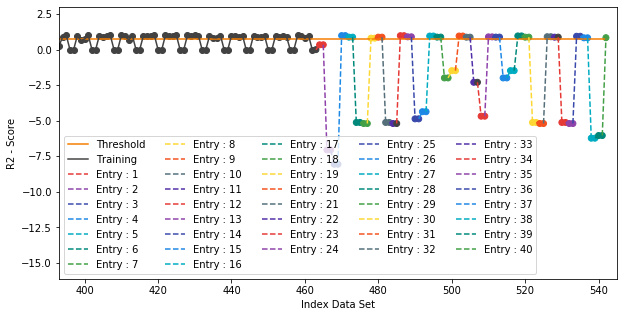

In [42]:
plotR2(r2_all)